In [1]:
import quandl
import datetime
import pandas as pd
import numpy as np

In [2]:
tickers = ["CME_CNH1", "ICE_MP2", "CME_RU1", "EUREX_FMMX2"]
names = ["cnh", "gbp", "rus", "mex"]

start = datetime.datetime(2015, 3, 1)
end = datetime.date.today()

dfs = [quandl.get("CHRIS/" + s, start_date=start, end_date=end) for s in tickers]
dfs = [df.Settle.rename(t.lower()) for t, df in zip(names, dfs)]

cnh = dfs[0]
# cnh_norm = np.log(cnh) - np.log(cnh.shift(1))
cnh.head()

Date
2015-03-02    6.2980
2015-03-03    6.2933
2015-03-04    6.2971
2015-03-05    6.2840
2015-03-06    6.2895
Name: cnh, dtype: float64

In [3]:
gbp = dfs[1]
rdx = dfs[2]
mex = dfs[3]
type(mex)

pandas.core.series.Series

In [4]:
futures = pd.concat([cnh, gbp, rdx, mex], axis=1)
futures.index = pd.to_datetime(futures.index, format="%Y-%m-%d")
print(futures.shape)
futures.head()

(977, 4)


,cnh,gbp,rus,mex
Date,,,,
2015-03-02,6.2980,1.5352,15890.0,563.5
2015-03-03,6.2933,1.5354,16070.0,561.5
2015-03-04,6.2971,1.5251,16055.0,551.0
2015-03-05,6.2840,1.5229,16380.0,552.0
2015-03-06,6.2895,1.5038,16535.0,548.0


In [5]:
futures.tail()

,cnh,gbp,rus,mex
Date,,,,
2018-12-03,6.8813,1.2797,15010.0,424.5
2018-12-04,6.8461,1.2786,14950.0,419.3
2018-12-05,6.8607,1.2804,15000.0,415.8
2018-12-06,6.8872,1.2842,14955.0,410.3
2018-12-07,6.8860,1.2817,15045.0,425.8


In [6]:
futures.isna().sum()

cnh    25
gbp     2
rus    24
mex    10
dtype: int64

In [7]:
def impute_df(df):
    df.interpolate(method="time", inplace=True)
        
impute_df(futures)

In [8]:
futures.isna().sum()

cnh    0
gbp    0
rus    0
mex    0
dtype: int64

In [9]:
futures = futures.resample("6H").interpolate(method="time", order=3)
futures.head()

,cnh,gbp,rus,mex
Date,,,,
2015-03-02 00:00:00,6.298000,1.53520,15890.0,563.5
2015-03-02 06:00:00,6.296825,1.53525,15935.0,563.0
2015-03-02 12:00:00,6.295650,1.53530,15980.0,562.5
2015-03-02 18:00:00,6.294475,1.53535,16025.0,562.0
2015-03-03 00:00:00,6.293300,1.53540,16070.0,561.5


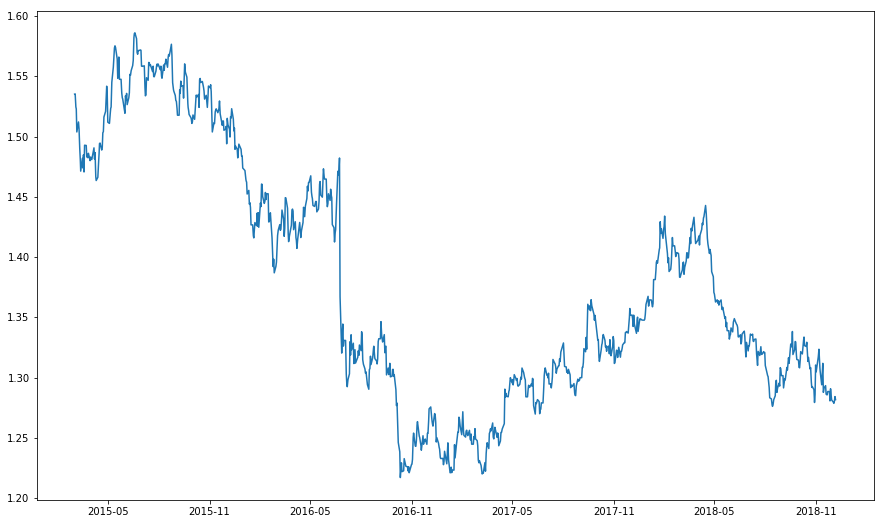

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.rcParams['figure.figsize'] = (15, 9)

plt.plot(futures.index, futures.gbp)

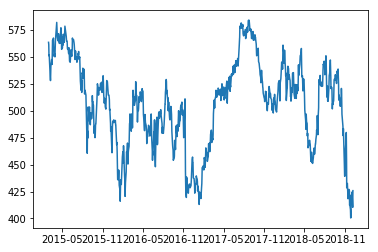

In [11]:
plt.plot(futures.index, futures.mex)

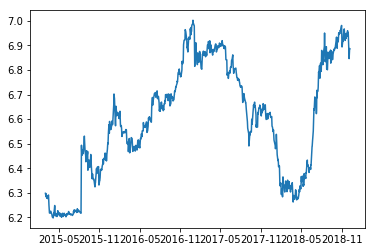

In [12]:
plt.plot(futures.index, futures.cnh)

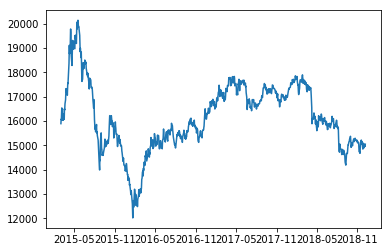

In [13]:
plt.plot(futures.index, futures.rus)

## Creating the Model for a single Feature

In [14]:
import tflearn as tf

forward = futures.cnh.shift(3)
forward.rename("result", inplace=True)

shifted = pd.concat([futures.cnh, forward], axis=1)
shifted.dropna(inplace=True)
print(shifted.shape)
shifted.head()

(5502, 2)


,cnh,result
Date,,
2015-03-02 18:00:00,6.294475,6.298000
2015-03-03 00:00:00,6.293300,6.296825
2015-03-03 06:00:00,6.294250,6.295650
2015-03-03 12:00:00,6.295200,6.294475
2015-03-03 18:00:00,6.296150,6.293300


In [15]:
steps = 30
features = 1
split = 4000

n_units = 128
eta = 0.3
X = shifted.cnh.values.reshape(1, -1)
y = shifted.result
my_x = np.empty([len(y),steps, features])

for i, _ in enumerate(X):
    time_chunk = X[i:i+steps,:]
    if time_chunk.shape == (steps, features):
        my_x[i,:,:] = time_chunk
    else:
        my_x[i,:,:] = np.ones((steps, features))


trainX, testX = my_x[:split, :], my_x[split:-2, :]
trainY, testY = y[:split], y[split:-2]
trainY = trainY.values.reshape(-1, 1)
testY = testY.values.reshape(-1, 1)

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(4000, 30, 1)
(1500, 30, 1)
(4000, 1)
(1500, 1)


In [16]:
inputs = tf.input_data(shape=[None, steps, features])
lstm = tf.lstm(inputs, n_units=n_units, activation="softsign", return_seq=False)
fc = tf.fully_connected(lstm, features, activation="linear")
loss = tf.regression(fc, optimizer='nesterov', loss='mean_square', learning_rate=eta)

model = tf.DNN(loss)

In [19]:
epochs = 10

# validation_losses = []
training_losses = []

model.fit(trainX, trainY, n_epoch=epochs, validation_set=0.1, batch_size=500)
predictY = np.array(model.predict(trainX))
training_losses.append(np.mean(predictY - trainY)**2)
   
print(i, end=" ")

Training Step: 239  | total loss: 0.05057 | time: 1.051s
| Nesterov | epoch: 030 | loss: 0.05057 -- iter: 3500/3600
Training Step: 240  | total loss: 0.05034 | time: 2.112s
| Nesterov | epoch: 030 | loss: 0.05034 | val_loss: 0.05801 -- iter: 3600/3600
--
1 

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)

plt.plot(training_losses, 100)

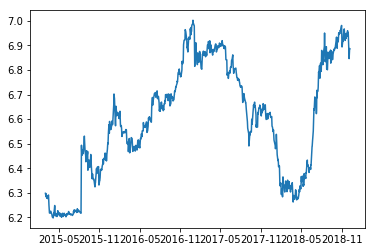

In [27]:
plt.plot(futures.index, futures.cnh)